# 阿里巴巴股票分析与预测

## 摘要

众所周知，如果你关心经济形式的话，最近美股的自由落体运动实在是非常的显著。诸多此前已经连续上涨十年，股价高高在上的美股公司最近已经基本上抹平了它们自特朗普上任以来的涨幅。中国的公司是否也受到了这样的影响呢？这由此引起了我的兴趣，能否从中国股市的诸多历史数据中找出一些我们感兴趣的pattern或者看到图形变化的趋势呢？因此我们挑出了阿里巴巴这样耳熟能详的大公司。来从诸多维度中查看和分析类似于风险度这样的特征，并且用不同的数学模型进行分析影响股价的因素，找到合适的影响因子对股价进行预测，研究适合用于预测股价，成交量的模型。

## 介绍

首先我们找到了一个关于阿里巴巴股票数据的中国财经网站(xueqiu.com)，通过连接这个网站的API，进行爬虫，获取需要的数据，最后保存到本地名为‘alibaba_stock.csv’，用于分析。

## 数据分析与预测
### 1.数据获取
首先我们需要安装和引入相应的依赖。如下列出了全部的依赖诸如pandas, numpy和seaborn。

In [170]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
import urllib.request
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from pylab import rcParams
from sklearn import neighbors


为了获取数据，我们需要调用顶点财经的api。顶点财经支持多种付费方式用以获取数据，我们分段购买了alibaba股票于2017年一月2日到2018年一月11日的数据来用作训练集。购买了2018年1月12日到2018年3月31日的数据来作为验证集。

一旦购买了数据时段，顶点财经将会生成不同的api key,我们需要此api key来作为api的参数传给顶点财经的子服务器。

In [64]:
def get_trainset():
    try:
        os.remove("./datasets/alibaba_stock.csv")
    except OSError:
        pass
    period_api_key = 'lqy@1023_NMss5Xyp42TnLD9tW9vANWMr'
    urllib.request.urlretrieve("http://54.252.212.31:10003/api/nasdaq/data/" + period_api_key,
                                "./datasets/alibaba_stock.csv")

def get_verify_set():
    try:
        os.remove("./datasets/alibaba_stock_verify.csv")
    except OSError:
        pass
    period_api_key = 'lqy@1023_AScv7POp39LaSK01W4qPOlaC'
    urllib.request.urlretrieve("http://54.252.212.31:10003/api/nasdaq/data/" + period_api_key,
                                    "./datasets/alibaba_stock_verify.csv")

get_trainset()
get_verify_set()

In [65]:
# 如果此时查看datasets目录会发现，我们通过api将两份数据集下载到了本地用以后续分析。

定义数据图的样式与属性

In [132]:
sns.set(style="ticks")
rcParams['figure.dpi'] = 80
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
# rcParams['figure.figsize'] = 7,5
rcParams['figure.figsize'] = 5,3
rcParams['font.size'] = 15

In [133]:
dt = pd.read_csv("./datasets/alibaba_stock.csv")

股票数据包括日期，最高价，最低价，开盘价，收盘价，成交量，恐慌程度，公司发生的时间，感兴趣程度，股票风险等

In [134]:
dt.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Panic,Event No,ROE,ETF,Risk
0,1.483355e+09,89.000000,88.080002,89.000000,88.599998,8789400,88.599998,NaN,-1.0,62.8,NO,3
1,1.483441e+09,90.889999,88.580002,88.985001,90.510002,11490200,90.510002,0.0,7.0,46.3,NO,5
2,1.483528e+09,94.809998,91.639999,91.910004,94.370003,16821500,94.370003,8.0,0.0,40.2,NO,3
3,1.483614e+09,94.500000,93.000000,94.400002,93.889999,7639800,93.889999,NaN,9.0,31.2,NO,5
4,1.483873e+09,95.650002,93.309998,94.160004,94.720001,10829500,94.720001,10.0,9.0,27.7,NO,3


### 2.数据分析

首先分析了阿里巴巴股票的股价

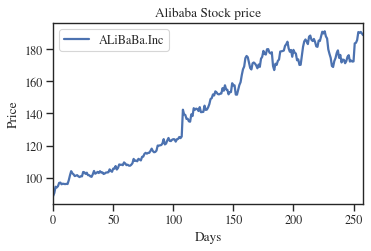

In [135]:
dt['Adj Close'].plot(legend=True,label='ALiBaBa.Inc')
plt.title('Alibaba Stock price', alpha=1)
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

然后分析了阿里巴巴每日成交量的波动情况

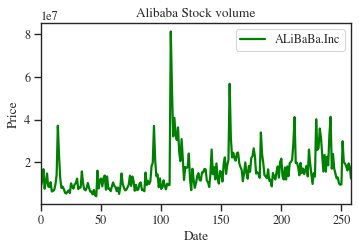

In [136]:
dt['Volume'].plot(legend=True,label='ALiBaBa.Inc',color='green')
plt.title('Alibaba Stock volume', alpha=1)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

股票单日的最大回撤

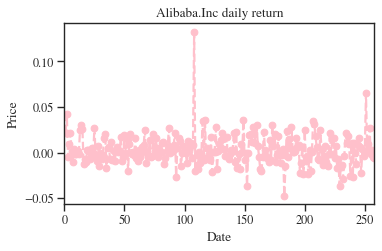

In [137]:
dt['daily return'] = dt['Adj Close'].pct_change()
dt['daily return'].plot(label='Alibaba.Inc',color='pink',linestyle='--',marker='o')
plt.title('Alibaba.Inc daily return', alpha=1)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

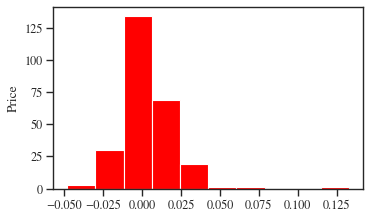

In [138]:
dt['daily return'].plot(label='Alibaba.Inc',color='red', kind='hist')
plt.ylabel("Price")
plt.show()

### 3.数据清洗

通过分析数据集可知，数据集中关于代表当日市场恐慌指数的值有部分的缺失。在查看此部分缺失数据的总体占比之后，我们发现其缺失比例可以进行较为有效的数据补全。因此我们需要将这部分缺失的值进行预测补全来提高数据的有用性。

选用随机森林可能会是一个比较好的方法，因为查看各种相关因子的关系较为独立，用基于决策树的方法去补值也是较为通行的做法。我们选用默认参数，因为sklearn的算法非常智能，会在构建决策树时自动优化权重，得出最熵树。

In [139]:
def estimate_missing_panic_value(data, scale):
    panic_related_elem = data[
        ['Panic', 'Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Event No', 'ROE']]

    known_panic = np.asmatrix(panic_related_elem[panic_related_elem.Panic.notnull()])
    unknown_panic = np.asmatrix(panic_related_elem[panic_related_elem.Panic.isnull()])

    y = known_panic[0:scale, 0]
    X = unknown_panic[:, 1:]

    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    predict_panic = rfr.predict(unknown_panic[:, 1::])

    data.loc[(data.Panic.isnull()), 'Panic'] = predict_panic
    return data, rfr

通过运行方法之后再进行数据检视，发现panic相关空值已经被替换成功。

In [140]:
dt, rfr = estimate_missing_panic_value(dt, 40)
dt.head()

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


,Date,High,Low,Open,Close,Volume,Adj Close,Panic,Event No,ROE,ETF,Risk,daily return
0,1.483355e+09,89.000000,88.080002,89.000000,88.599998,8789400,88.599998,2.609,-1.0,62.8,NO,3,NaN
1,1.483441e+09,90.889999,88.580002,88.985001,90.510002,11490200,90.510002,0.000,7.0,46.3,NO,5,0.021558
2,1.483528e+09,94.809998,91.639999,91.910004,94.370003,16821500,94.370003,8.000,0.0,40.2,NO,3,0.042647
3,1.483614e+09,94.500000,93.000000,94.400002,93.889999,7639800,93.889999,8.188,9.0,31.2,NO,5,-0.005086
4,1.483873e+09,95.650002,93.309998,94.160004,94.720001,10829500,94.720001,10.000,9.0,27.7,NO,3,0.008840


接下来需要处理非连续值，我们发现ETF指标（代表是否被当日被市场场内基金买入）是非线性连续值。这样的值我们在构建线性回归模型或者knn模型的时候是无法被算法直接使用的，因此我们需要做处理，将其变为线性连续数值。通常的坐标维度的二值化做法就可以很好解决。

首先进行坐标拆分，将单独的ETF拆分为ETF_YES和ETF_NO两个系数。

In [141]:
def set_ETF_STREAM_IN(dt):
    dt.loc[(dt.ETF == "YES"), 'ETF'] = "Yes"
    dt.loc[(dt.ETF == "NO"), 'ETF'] = "No"
    return dt

In [142]:
def dummy_flat_ETF(dt):
    flat_ETF = pd.get_dummies(dt['ETF'], prefix='ETF')
    dt = pd.concat([dt, flat_ETF], axis=1)
    dt.drop(['ETF'], axis=1, inplace=True)
    return dt

之后处理原坐标下的YES和NO值，进行新系数下的mapping。通过打印输出处理数据我们发现，数据被成功处理平铺。

In [143]:
dt = set_ETF_STREAM_IN(dt)
dt = dummy_flat_ETF(dt)
dt.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Panic,Event No,ROE,Risk,daily return,ETF_No,ETF_Yes
0,1.483355e+09,89.000000,88.080002,89.000000,88.599998,8789400,88.599998,2.609,-1.0,62.8,3,NaN,1,0
1,1.483441e+09,90.889999,88.580002,88.985001,90.510002,11490200,90.510002,0.000,7.0,46.3,5,0.021558,1,0
2,1.483528e+09,94.809998,91.639999,91.910004,94.370003,16821500,94.370003,8.000,0.0,40.2,3,0.042647,1,0
3,1.483614e+09,94.500000,93.000000,94.400002,93.889999,7639800,93.889999,8.188,9.0,31.2,5,-0.005086,1,0
4,1.483873e+09,95.650002,93.309998,94.160004,94.720001,10829500,94.720001,10.000,9.0,27.7,3,0.008840,1,0


分析了阿里巴巴股票的相对恐慌值，风险系数，和ROE系数。我们可以绘图来更加直观的检视效果。

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0, flags=flags)


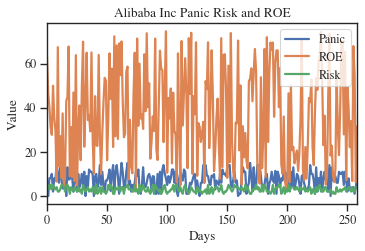

In [144]:
dt['Panic'].plot(legend=True,label='Panic')
dt['ROE'].plot(legend=True,label='ROE')
dt['Risk'].plot(legend=True,label='Risk')
plt.title('Alibaba Inc Panic，Risk and ROE', alpha=1)
plt.xlabel("Days")
plt.ylabel("Value")
plt.show()

### 4.模型预测

首先利用线性回归模型来分析和预测股票的单日成交量和单日股价最高值之间的关系。可以通过调用库函数来直观的得到诸如直方分布，指标标准差之类的数据。

In [145]:
mod = smf.ols(formula='High ~ 1 + Volume', data=dt.dropna()).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   High   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     58.09
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           4.88e-13
Time:                        21:32:39   Log-Likelihood:                -1238.9
No. Observations:                 258   AIC:                             2482.
Df Residuals:                     256   BIC:                             2489.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    121.1976      3.607     33.599      0.000     114.094     128.301
Volume      1.511e-06   1.98e-07      7.622      0.000    1.12e-06     1.9e-06
==============================================================================
Omnibus:                       26.961   Durbin-Watson:                   0.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.790
Skew:                          -0.109   Prob(JB):                       0.0123
Kurtosis:                       2.122   Cond. No.                     3.57e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

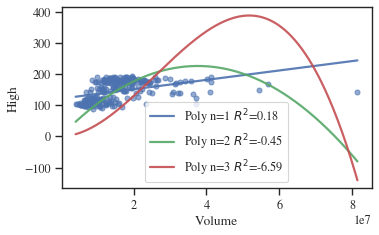

In [146]:
plt.scatter(dt.Volume, dt.High, s=20, alpha=0.6)
x = pd.DataFrame({'Volume': np.linspace(dt.Volume.min(), dt.Volume.max(), len(dt.Volume)) })

# 1-st order polynomial
poly_1 = smf.ols(formula='High ~ 1 + Volume', data=dt.dropna()).fit()
plt.plot(x, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared,  alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='High ~ 1 + Volume + I(Volume ** 2.0)', data=dt.dropna()).fit()
plt.plot(x, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='High ~ 1 + Volume + I(Volume ** 2.0) + I(Volume ** 3.0)', data=dt.dropna()).fit()
plt.plot(x, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)
plt.xlabel('Volume')
plt.ylabel('High')
plt.legend()

用不同参数的KNN的模型分析和预测ROE和单日成交量之间的关系。The KNN models with k=3, k=5, and k=10 were established respectively. 可以通过plt库函数绘图来查看模型曲线与真实数据点的拟合程度。

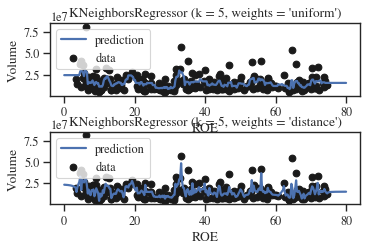

In [147]:
X = dt.ROE.values
X = np.reshape(X, (len(dt.ROE), 1))
x = np.linspace(0, 80, 300)[:, np.newaxis]
y = dt.Volume.values
y = np.reshape(y, (len(dt.Volume), 1))
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_hat = knn.fit(X, y).predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(x, y_hat, c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('ROE')
    plt.ylabel('Volume')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()

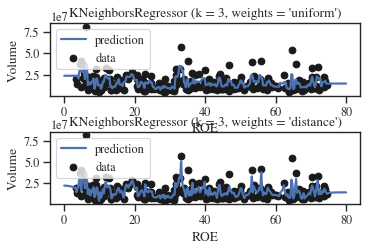

In [148]:
X = dt.ROE.values
X = np.reshape(X, (len(dt.ROE), 1))
x = np.linspace(0, 80, 300)[:, np.newaxis]
y = dt.Volume.values
y = np.reshape(y, (len(dt.Volume), 1))
n_neighbors = 3

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_hat = knn.fit(X, y).predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(x, y_hat, c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('ROE')
    plt.ylabel('Volume')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()

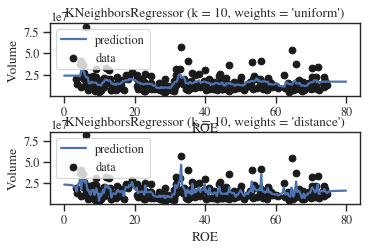

In [149]:
X = dt.ROE.values
X = np.reshape(X, (len(dt.ROE), 1))
x = np.linspace(0, 80, 300)[:, np.newaxis]
y = dt.Volume.values
y = np.reshape(y, (len(dt.Volume), 1))
n_neighbors = 10

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_hat = knn.fit(X, y).predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(x, y_hat, c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('ROE')
    plt.ylabel('Volume')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()

In [150]:
def calculate_regression_goodness_of_fit(ys, y_hat):
    ss_total = 0
    ss_residual = 0
    ss_regression = 0
    y_mean = y.mean()
    
    for i in range(len(ys)):
        ss_total += np.square(ys[i] - y_mean)
        ss_residual += np.square(ys[i] - y_hat[i])
        ss_regression += np.square(y_hat[i] - y_mean)
    
    r_square = ss_regression / ss_total
    rmse = np.sqrt( ss_residual / float(len(ys)) )
    
    return r_square[0], rmse[0]
    

In [151]:
rsquare_arr = []
rmse_arr = []

for k in range(2, len(y)):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    y_hat = knn.fit(X, y).predict(x)
    rsquare, rmse = calculate_regression_goodness_of_fit(y, y_hat)
    rmse_arr.append(rmse)
    rsquare_arr.append(rsquare)

Text(0.5, 1.0, 'RMSE for the KNeighborsRegressor')

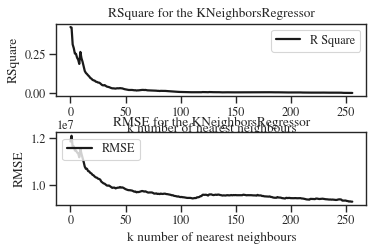

In [152]:
plt.subplot(2, 1, 1)
plt.plot(range(0, 257), rsquare_arr, c='k', label='R Square')
plt.axis('tight')
plt.xlabel('k number of nearest neighbours')
plt.ylabel('RSquare')
plt.legend(loc='upper right')
plt.title("RSquare for the KNeighborsRegressor")
plt.subplots_adjust( hspace=0.5)

plt.subplot(2, 1, 2)
plt.plot(range(0, 257), rmse_arr, c='k', label='RMSE')
plt.axis('tight')
plt.xlabel('k number of nearest neighbours')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.title("RMSE for the KNeighborsRegressor")

对于线性回归类型的模型构建来说，如果默写系数所代表的数据集它们的散列范围过大或者不均匀的话，会影响梯度下降的过程导致模型无法快速收敛或者构建速度过慢，因此对于此种类型的数据我们还需要进行范围收缩。以ROE为例，它的值分布范围过于离散且跨度较大，因此我们把他用scale库函数进行收敛处理，使得其范围控制在-2到2之间，用以提升模型有效性和效率。

In [153]:
def minimize_scale(dt):
    scaler = preprocessing.StandardScaler()
    age_scale_param = scaler.fit(dt[['ROE']])
    dt[['ROE']] = scaler.fit_transform(dt[['ROE']], age_scale_param)
    return dt

In [154]:
dt = minimize_scale(dt)
print(dt)

             Date        High         Low        Open       Close    Volume  \
0    1.483355e+09   89.000000   88.080002   89.000000   88.599998   8789400   
1    1.483441e+09   90.889999   88.580002   88.985001   90.510002  11490200   
2    1.483528e+09   94.809998   91.639999   91.910004   94.370003  16821500   
3    1.483614e+09   94.500000   93.000000   94.400002   93.889999   7639800   
4    1.483873e+09   95.650002   93.309998   94.160004   94.720001  10829500   
..            ...         ...         ...         ...         ...       ...   
254  1.515064e+09  190.750000  186.300995  187.169998  190.699997  18168300   
255  1.515323e+09  191.660004  189.070007  190.460007  190.330002  16230100   
256  1.515409e+09  192.490005  188.000000  191.130005  190.800003  19495100   
257  1.515496e+09  190.389999  186.580002  188.100006  189.789993  17943800   
258  1.515582e+09  190.429993  188.100006  189.729996  188.750000  12400400   

      Adj Close   Panic  Event No       ROE  Risk  

# 4.模型构建和可信度分析

对于Knn模型的构建，先通过从预处理数据集中读取系数名称，并重新sort系数列位置。并通过正则名称匹配找出用于构建的系数及其数据。我们可以去替换其中的邻居数量，来观察模型构建的精确程度。

In [155]:
def knn(dt):
    columns_titles = ["Risk", "Date", "High", "Low", "Open", "Close", "Volume", "Adj Close", "Panic", "Event No", "ROE",
                      "ETF_Yes", "ETF_No"]
    dt = dt.reindex(columns=columns_titles)
    train_dt = dt.filter(regex='Risk|Date|High|Low|Open|Close|Volume|Adj Close|Panic|Event No|ROE|ETF_Yes|ETF_No')
    train_np = np.asmatrix(train_dt)
    y = train_np[:, 0]
    x = train_np[:, 1:]
    kNeighbour = 20
    model = KNeighborsClassifier(12, weights='uniform', algorithm='auto')
    model_with_k_3 = model.fit(x, y)

    # kNeighbour = 8
    # model = KNeighborsClassifier(8,  weights='uniform', algorithm='auto')
    # model_with_k_8 = model.fit(x, y)
    return model_with_k_3

在模型构建完成候，我们得到了以邻居数为3的knn模型。下面用我们通过训练集训练出的模型来验证验证数据集中的数据。

In [156]:
knn_modle = knn(dt)

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


关于验证函数，我们主要根据预估的结果和验证数据集中的真实数据进行比较，最后计算出正确结果所占的百分比。

In [157]:
def verify(modle):
    dt = pd.read_csv("./datasets/alibaba_stock_verify.csv")
    dt, rfr = estimate_missing_panic_value(dt, 2)
    dt = set_ETF_STREAM_IN(dt)
    dt = dummy_flat_ETF(dt)
    dt = minimize_scale(dt)
    columns_titles = ["Risk", "Date", "High", "Low", "Open", "Close", "Volume", "Adj Close", "Panic", "Event No", "ROE",
                      "ETF_Yes", "ETF_No"]
    dt = dt.reindex(columns=columns_titles)
    train_dt = dt.filter(regex='Risk|Date|High|Low|Open|Close|Volume|Adj Close|Panic|Event No|ROE|ETF_Yes|ETF_No')
    train_np = np.asmatrix(train_dt)
    y = train_np[:, 0]
    x = train_np[:, 1:]
    res = np.round(modle.predict(x))
    return res

以传入k=3的knn模型为例，我们可以得出预测准确率为60%。

In [158]:
res = verify(knn_modle)

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


In [159]:
def result_compare_statistic(res):
    origin_data_train = pd.read_csv("./datasets/alibaba_stock_verify.csv")
    origin_data_train = origin_data_train.filter(regex='Risk')
    correctTotal = 0
    dataTotal = origin_data_train.size
    for i in range(0, origin_data_train.size):
        if (origin_data_train.to_numpy()[i] == res[i]):
            correctTotal = correctTotal + 1
    print("predict successful percentage is:" + str((correctTotal / dataTotal) * 100))

In [160]:
result_compare_statistic(res)

predict successful percentage is:60.0


同理，我们来构建simple regression的模型。依旧是根据系数resort出x和y,然后传入系数数据和结果数据进行训练。基于sk learn库函数的智能处理，会自动平衡系数权值来获得最优解。

In [161]:
def simple_regression(dt):
    columns_titles = ["Risk", "Date", "High", "Low", "Open", "Close", "Volume", "Adj Close", "Panic", "Event No", "ROE",
                      "ETF_Yes", "ETF_No"]
    dt = dt.reindex(columns=columns_titles)
    train_dt = dt.filter(regex='Risk|Date|High|Low|Open|Close|Volume|Adj Close|Panic|Event No|ROE|ETF_Yes|ETF_No')
    train_np = np.asmatrix(train_dt)
    y = train_np[:, 0]
    x = train_np[:, 1:]
    simple_model = linear_model.LinearRegression()
    simple_model.fit(x, y)
    return simple_model

经过训练以后，得到简单回归模型。

In [162]:
simple_reg_modle = simple_regression(dt)

根据训练模型，加载验证集x系数，预测risk值。可以得出验证准确率是35%。

In [163]:
res = verify(simple_reg_modle)
result_compare_statistic(res)

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


predict successful percentage is:30.0


同理，多项式模型的构建。一样分离出系数数据x数组和risk作为y结果集，传入sklearn进行自动模型构建。我们传入多项式系数degree为2。

In [164]:
def polynomial_regression(dt):
    poly_reg = PolynomialFeatures(degree=2)
    columns_titles = ["Risk", "Date", "High", "Low", "Open", "Close", "Volume", "Adj Close", "Panic", "Event No", "ROE",
                      "ETF_Yes", "ETF_No"]
    dt = dt.reindex(columns=columns_titles)
    train_dt = dt.filter(regex='Risk|Date|High|Low|Open|Close|Volume|Adj Close|Panic|Event No|ROE|ETF_Yes|ETF_No')
    train_np = np.asmatrix(train_dt)
    y = train_np[:, 0]
    x = train_np[:, 1:]
    # x = np.array(x).reshape(len(x))
    x_poly = poly_reg.fit_transform(x)
    lin_reg = linear_model.LinearRegression()
    modle = lin_reg.fit(x_poly, y)
    return modle

得到多项式回归模型，

In [165]:
modle = polynomial_regression(dt)

之后进行验证，得到以该模型进行预测，准确率为10%。

In [166]:
def polynominal_verify(modle):
    dt = pd.read_csv("./datasets/alibaba_stock_verify.csv")
    dt, rfr = estimate_missing_panic_value(dt, 2)
    dt = set_ETF_STREAM_IN(dt)
    dt = dummy_flat_ETF(dt)
    dt = minimize_scale(dt)
    columns_titles = ["Risk", "Date", "High", "Low", "Open", "Close", "Volume", "Adj Close", "Panic", "Event No", "ROE",
                      "ETF_Yes", "ETF_No"]
    dt = dt.reindex(columns=columns_titles)
    train_dt = dt.filter(regex='Risk|Date|High|Low|Open|Close|Volume|Adj Close|Panic|Event No|ROE|ETF_Yes|ETF_No')
    train_np = np.asmatrix(train_dt)
    x = train_np[:, 1:]
    poly_reg = PolynomialFeatures(degree=2)
    x_poly = poly_reg.fit_transform(x)
    res = np.round(modle.predict(x_poly)) - 1
    return res

In [167]:
res = polynominal_verify(modle)
result_compare_statistic(res)

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


predict successful percentage is:25.0


最后，进行logistic regression模型构建.

In [168]:
def logistic_regression(dt):
    columns_titles = ["Risk", "Date", "High", "Low", "Open", "Close", "Volume", "Adj Close", "Panic", "Event No", "ROE",
                      "ETF_Yes", "ETF_No"]
    dt = dt.reindex(columns=columns_titles)
    train_dt = dt.filter(regex='Risk|Date|High|Low|Open|Close|Volume|Adj Close|Panic|Event No|ROE|ETF_Yes|ETF_No')
    train_np = np.asmatrix(train_dt)
    y = train_np[:, 0]
    x = train_np[:, 1:]
    clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6, solver='liblinear')
    clf.fit(x, y)
    return clf

根据得到的模型进行回归预测，再与验证数据集中的数据结果进行比较，得到准确率为75%。算是比较理想的准确率。

In [169]:
reg_modle = logistic_regression(dt)
res = verify(reg_modle)
result_compare_statistic(res)

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] =

predict successful percentage is:75.0


# 5. 结论

通过对以上的不同模型准确率进行分析，发现logistic模型具有较高的准确率，knn模型次之，拥有60%的准确率，简单线性回归和多项式回归拟合效果较差。但是提升准确度依赖于更多的数据和模型调参，这有待与之后更加仔细的优化。